# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers
###  Project Overview

In my capstone project, I aim to answer 2 main business questions:

1.An effective offer on the Starbucks app depends on which drivers?

2.Could whether a user would take up an offer or not be predicted using the data provided? 

To answer the above 2 questions, I have created a scenario which contains 3 models depending upon the three offer types. The three offer types are:Discount (discount with purchase),Informational (provides information about products), Buy One Get One Free (BOGO).


### Problem Statement
The data provided consists of 3 datasets:

* Offer portfolio, which consists of the attributes of each offer
* Demographic data for each customer
* Transactional records of events occurring on the app
I have used 3 classification supervised machine learning models, feeding in the data from three different offer types.

I have used the model to uncover the feature importances to identify the drivers of offer effectiveness, while exploring if the model itself could be used to predict if a user would take up an offer.

Lastly, I also explore the characteristics of users who do or do not take up an offer.

My project aims to answer the two questions above, but I also ended up adding 2 additional models as points of exploration - the first assessing whether an all-in-one model could be used in place of 3 different models, with the offer types functioning as a categorical variable. Secondly, I also build a regression model to see if we could predict the amount a user would spend, given that the offer is effectively influencing them.

As stated above, the problem statement I am aiming to answer are to 

(1) discover the main drivers of offer effectiveness,and

(2) explore if we can predict whether a user would take up an offer.




In [3]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
% matplotlib inline


# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Part 1: Data Explorationand Cleaning

### 1.1 Portoflio Dataset Feature Engineering

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [9]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

### 1.2 Profile Dataset Feature Engineering

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
#checking for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

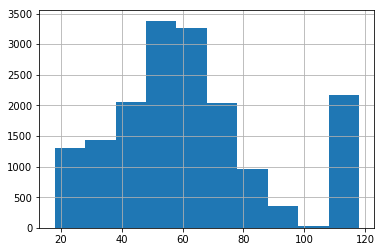

In [12]:
#check distribution of age column
profile.age.hist()


We can see above that the age = 118 value does not make sense there as it is clearly out of the normal distribution.

In [13]:
#checking count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


As we can see above, the age=118 column corresponds with the null gender and income columns. Thus, we can actually drop them during preprocessing if they do not take too large a proportion of our data.



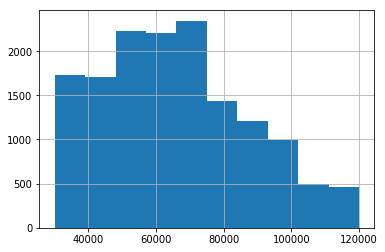

In [14]:
#check distributions of income
profile.income.hist()


the became_member_on column has some potential to be feature engineered to get the tenure of membership in days. This feature might have some influence on whether an offer is effective or not.

In [16]:
profile.became_member_on.head()


0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

### 1.3 Transcript Dataset Feature Engineering

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

This data looks a bit more tricky, as it is ordered by time and has an event and value. In particular, the value column will have to be preprocessed depending on the event.

In [21]:
#checking number of unique people represented
transcript['person'].nunique()

17000

It looks as though the number of people in transcript are the same as the number of people in the Demographics Data, so that is good news. But a lot of preprocessing will need to be done in order to extract meaningful insights out of this dataset

In [22]:
#checking null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [23]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [24]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

(this error occurred because i ran it again after removing the offer id column so please ignore) 

In [25]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Preprocessing of data for the model
In order to identify the main drivers of an effective offer, I have to first define what an 'effective' offer is within the Starbucks app. Thus, I did some further exploration on the datasets and how all three would interact.

First, I had to explore what kind of events are within each offer type.

In [26]:
#rename column
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [27]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

The first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.

Moreover, we also know that BOGO and discount offers have an offer completed event when offers are completed. However, informational offers do not have this event associated with it. Thus, we also have to specify the approach to define an effective offer as follows:

For a BOGO and discount offer, an effective offer would be defined if the following events were recorded in the right sequence in time:

offer received ->offer viewed ->transaction ->offer completed

 since there offer completed event associated with it, I will have to define transactions as a conversion to effective offer:

offer received -> offer viewed -> transaction

###  Exploring the Data

### a.Assigning offer ids to transactions

After defining the approach above, we now have to explore methods to assign offer_ids to specific transactions. Among the considerations is to define the following main groups of customers:1. People who are influenced and successfully convert - effective offers:

1. People who are influenced and successfully convert - effective offers

2. People who received and viewed an offer but did not successfully convert - ineffective offers

3. People who purchase/complete offers regardless of awareness of any offers

In [28]:
#define dropcolumns function 
def drop_cols(drop_cols,df,inplace=False):
    '''
    input:
    - drop_cols: list of column name to be dropped
    - df: dataframe from which column should be dropped
    output:
    - Returns dataframe with dropped columns.
       
    '''
    df=df.drop(columns=drop_cols,axis=1,inplace=inplace)
    return df

In [29]:
#drop unnecessary columns to clean dataset
transcript=drop_cols(['reward_x','reward_y'],transcript)
#sort events by person and time
transcript=transcript.sort_values(['person','time'])

In [30]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offers_view_transacted=transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offers_view_transacted['offer_id']=offers_view_transacted['offer_id'].ffill()

In [31]:
transcript=transcript.merge(offers_view_transacted,how='left',on=['person','time','event'])

In [32]:
#clean up dataset to unify multiple offer_id columns into one column
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])

drop_cols(['offer_id_x','offer_id_y'],transcript,inplace=True);

In [33]:
#merge portfolio dataset again to get offer data for the transaction events
transcript=transcript.merge(portfolio,how='left',on='offer_id')
transcript['duration']=np.where(transcript['duration_x'].isnull(),transcript['duration_y'],transcript['duration_x'])
drop_cols(['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],transcript,inplace=True);
transcript.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [34]:
transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


### b.transactions and offers completed after offers viewed
Using our dataset with the offer_ids populated for transaction events, we can flag the converted transactions and completed offers. We have to first ensure that the offer id of the previous event is the same one. Since we have tagged the offer id for all viewed, transactions and completed offers, we can use the offer_id field to ensure that the previous offer consists of those events.

In [35]:
#get sample space of events consisting of offer viewed, transactions and offer completed
offers_viewed_transactions_completed=transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()

In [36]:
#add extra column to flag the previous offer id
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()

In [37]:
#flag a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)

In [38]:
#get only offer received events
offers_received=transcript[transcript['event']=='offer received'].copy()

#ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

#append datasets to complete dataset of transactions
transcript=offers_received.append(offers_viewed_transactions_completed)

#sort values
transcript=transcript.sort_values(['person','time'])

Having assigned offer_ids for transactions for which an offer viewed event occurred prior, we can now revisit the four customer groups of unique person-offer_id pairs we are trying to analyse

In [39]:
def split(offer_type,grp_df):
    '''
    input:
    - offer_type: specify name of offer type  in string format 
    - grp_df: original transcript dataframe to split on offer type
    
    output:
    - df-dataframe containing data of offer type.
       
    '''
    df=grp_df[grp_df['offer_type']==offer_type].copy()
    return df

#split transcript into 3 different offer types
transcript_bogo=split('bogo',transcript)
transcript_discount=split('discount',transcript)
transcript_info=split('informational',transcript)

For BOGO and discount offers, we will only consider offer completed events as the conversion events, while we can consider transaction event as the conversion event for the informational offers.

In [40]:
#function for for both BOGO and discount 
def grp1(df):
    '''
    input:
    - df: original transcript dataframe 

    output:
     grp1-dataframe containing transcript data of just group 1 users.
       
    '''
    grp1=df[['person','offer_id']][(df['valid_completed']==1) & (df['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
    return grp1

grp1_bogo=grp1(transcript_bogo)
grp1_discount=grp1(transcript_discount)

In [41]:

#again, we define a function for  BOGO & discount
def no_conv(df):
    
    '''
    input:
    - df: original transcript dataframe of specific offer type 
    
    output:
     check_merge=dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    
    '''
    
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    return check_merge

#check how many are in either group
check_merge_bogo=no_conv(transcript_bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=no_conv(transcript_discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


In [42]:
#define group 2 & 4 function as will repeat this for BOGO and discount offers
def grp_2_4(df):
    
    '''
    input:
    - df: output dataframe from no_conv function
    
    outputs:
    grp2,grp4- 2 dataframes containing unique person-offer_id pairs with dataframe containing only group2 customers first, followed by dataframe containing only group 4 customers. 
       
    '''
    
    #subset to check group 2 and 4
    grp_2_4=df[df['_merge']=='right_only']

    #remerge with transcript to get events
    grp_2_4=grp_2_4.merge(transcript,how='left',on=['person','offer_id'])

    #within this subset, separate people with offer viewed event, and people with offer received but no offer viewed
    grp2=grp_2_4[['person','offer_id']][grp_2_4['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
    
    #remerge with full dataset and get remaining to get grp4
    drop_cols('_merge',grp_2_4,inplace=True)
    grp4=grp_2_4.merge(grp2[['person','offer_id']],how='left',indicator=True)
    grp4=grp4[grp4['_merge']=='left_only'].copy()
    
    return grp2,grp4

grp2_bogo,grp4_bogo=grp_2_4(check_merge_bogo)
grp2_discount,grp4_discount=grp_2_4(check_merge_discount)

Group 3 people are everyone in the converted ids who do not have an offer viewed prior - hence, they would be people with conversion events but no offer viewed event prior. For BOGO and discount offers, they would be people with offer completed events that have valid_completed != 1.

In [43]:
def grp3(df):
    '''
    input:
    - df: original transcript dataframe of specific offer type 
    
    output:
    grp3- dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
       
    '''
    
    #check all conversion events with invalid conversions
    grp3=df[['person','offer_id']][(df['event']=='offer completed') & (df['valid_completed']!=1)].groupby(['person','offer_id']).count().reset_index()
    return grp3

grp3_bogo=grp3(transcript_bogo)
grp3_discount=grp3(transcript_discount)

Now we have splited our data into 4 different customer groups for the BOGO and discount offers. Next, we have to consider the effective and ineffective offers depending on the group type. As already elaborated above, any unique person-offer_id belonging to group 1 can be considered in our target variable effective_offer=1 group.

In [44]:
def offers(grp1,grp2):
    '''
    input:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    output:
    offers- dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    grp1['effective_offer']=1
    grp2['effective_offer']=0

    #append datasets together
    offers=grp1.append(grp2,sort=False)
    return offers

offers_bogo=offers(grp1_bogo,grp2_bogo)
offers_discount=offers(grp1_discount,grp2_discount)

Now we have successfully prepared the target variables for our BOGO and discount datasets.

### c. Considering duration/validity of offers in converted transactions from informational offers

In [45]:
transcript_info['day_offer']=transcript_info['time']/24
#drop unnecessary columns
drop_cols(['time','value','offer_id_previous'],transcript_info,inplace=True);

#sort transactions to ensure all events occurring by person and offer
transcript_info=transcript_info.sort_values(['person','day_offer','event','offer_id'])

In [46]:
#get difference in time for informational offers
transcript_info['diff_info']=transcript_info[(transcript_info['offer_type']=='informational') & ((transcript_info['event']=='offer received') | (transcript_info['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [47]:
#create column for flagging valid events
transcript_info['valid_completed_duration']=np.nan

#flag valid events if within duration
transcript_info.loc[transcript_info['diff_info']<=transcript_info['duration'],'valid_completed_duration']=1

#fill any missing values with 0 flag
transcript_info['valid_completed_duration']=transcript_info['valid_completed_duration'].fillna(value=0)

In [48]:
#flag effective_offers where valid_completed=1 and valid_completed_duration=1
transcript_info['effective_offer']=np.where(((transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']==1)),1,0)


In [49]:
#separate group 1 in transcript_into
grp1_info=transcript_info[['person','offer_id']][transcript_info['effective_offer']==1].groupby(['person','offer_id']).sum().reset_index()

From the remaining people, we have to separate it out into groups 2 and 4. We can use similar steps to what we did with BOGO and Discount offers, since we don't have the duration consideration.

In [50]:
#separate out group 2 of customers
check_merge_info=no_conv(transcript_info)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())


For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [51]:
grp2_info,grp4_info=grp_2_4(check_merge_info)

In [52]:
#scenario 1
grp3_1=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']!=1) & (transcript_info['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
grp3_2=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2


In [53]:
offers_info=offers(grp1_info,grp2_info)

### d. Feature engineering

In [54]:
#rename column for merging
profile.rename(columns={'id':'person'},inplace=True)

#create function to reuse for 3 datasets
def member(df):
    '''
    input:
    - df: original dataframe
    
    outputs:
    df-  dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df=drop_cols('became_member_on',df)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df=drop_cols(['year','month','day'],df)
    
    return df

offers_bogo=member(offers_bogo)
offers_discount=member(offers_discount)
offers_info=member(offers_info)

#### Count of offers received

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


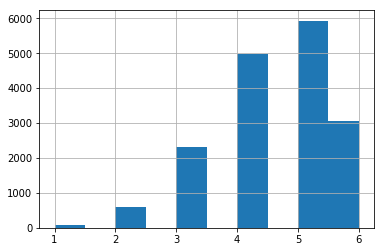

In [55]:
#group event=offer received per person in transactional records
print(transcript[transcript['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript[transcript['event']=='offer received'].groupby('person')['event'].count().hist()

In [56]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt=transcript[transcript['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
drop_cols('time',df_offer_received_cnt,inplace=True)

#ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

#### Separating user behaviours by transactions

In [57]:
#filter dataset by invalid transactions
df_transactions_invalid=transcript[(transcript['event']=='transaction') & (transcript['valid_completed']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns={'amount':'amount_invalid'},inplace=True)

#### Time elapsed between offers received

In [58]:
transcript['day_offer']=transcript['time']/24
#drop unnecessary columns
drop_cols(['time'],transcript,inplace=True);

#find time elapsed between offers received
transcript['time_elapsed_offers']=transcript[transcript['event']=='offer received'].groupby(['person','offer_id'])['day_offer'].diff()

#fill missing values with 0, as if someone does not receive an offer or is receiving an offer for the first time, there is no time elapsed
transcript['time_elapsed_offers']=transcript['time_elapsed_offers'].fillna(value=0)

#create temporary dataset
df_time_elapsed=transcript.groupby(['person','offer_id'])['time_elapsed_offers'].sum().reset_index()

###   Data Implementation

In [59]:
#merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [60]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid            96.323752
income                     7.057489
gender                     7.057489
offer_received_cnt         0.000000
membership_tenure_days     0.000000
dtype: float64

In [61]:
#fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)

#drop income and gender null rows
offers_bogo.dropna(inplace=True);

In [62]:
#foresee need to reuse function so create rename function
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=drop_cols(col,df)
    return df

In [63]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

#convert channels into categorical variables
channels = offers_bogo['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
offers_bogo=pd.concat([offers_bogo[:], channels[:]], axis=1)
rename('web',offers_bogo)
rename('email',offers_bogo)
rename('mobile',offers_bogo)
rename('social',offers_bogo)
offers_bogo=drop_cols('channels',offers_bogo)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

In [64]:
def prep_offers_df(df):
    
    '''
    input:
      df: original dataframe
    outputs:
     df-dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',on='offer_id')

    #convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
    df=pd.concat([df[:], channels[:]], axis=1)
    rename('web',df)
    rename('email',df)
    rename('mobile',df)
    rename('social',df)
    df=drop_cols('channels',df)
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')

    return df

In [65]:
#prepare data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

In [66]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info=drop_cols('index',offers_info.reset_index())

#expand channel column into categorical variables
def channel_col(name,df=offers_info):
    '''
    input:
    - name: name of channel column 
    - df: dataframe 
    
    output:
     df-offer_info dataframe with channel column transformed
    
    '''
    df[name]= np.nan
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name]=1
    df[name]=df[name].fillna(value=0)
    return df

In [67]:
channel_col('web')
channel_col('email')
channel_col('mobile')
channel_col('social');

drop_cols('channels',offers_info,inplace=True);

In [68]:
def prep_offers_df(df):
    '''
    inpus:
    - df: dataframe to be transformed 
    
    output:
    df-dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')
    return df

In [69]:
offers_info=prep_offers_df(offers_info)

In [70]:
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_tenure_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,1,0,0


In [71]:
#check multiple records for each person and offer ids for the target variable
print((offers_bogo.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_discount.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_info.groupby(['person','offer_id','effective_offer']).size()>1).sum())

0
0
0


In [72]:
#check for class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


### Model Implementation

In [73]:
def data_prep(df,drop_cols_prep):
    '''
    input:
    - df: prepared dataframe for modeling 
    
    output:
     features and target dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = drop_cols(drop_cols_prep,df)
    return features,target

In [75]:
def model_pipeline(features,target):
    '''
    input:
    - features & target dataframe 
    
    output:
      X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=50)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [76]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    input:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    output:
       results
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [77]:
def run_model(clf1,clf2,name):
    '''
    input:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    
    
    outputs:
    results- Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

 #### BOGO offers model

In [78]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1756
MSE_test: 0.1867
Training accuracy:0.8244
Test accuracy:0.8133
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       459
          1     0.8133    1.0000    0.8970      1999

avg / total     0.6614    0.8133    0.7295      2458



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1658
MSE_test: 0.1835
Training accuracy:0.8342
Test accuracy:0.8165
             precision    recall  f1-score   support

          0     0.5625    0.0784    0.1377       459
          1     0.8233    0.9860    0.8973      1999

avg / total     0.7746    0.8165    0.7555      2458



#### Discount offers model

In [79]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)


DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1340
MSE_test: 0.1403
Training accuracy:0.8660
Test accuracy:0.8597
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       357
          1     0.8597    1.0000    0.9246      2188

avg / total     0.7391    0.8597    0.7949      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1289
MSE_test: 0.1391
Training accuracy:0.8711
Test accuracy:0.8609
             precision    recall  f1-score   support

          0     0.6154    0.0224    0.0432       357
          1     0.8622    0.9977    0.9250      2188

avg / total     0.8275    0.8609    0.8013      2545



#### Informational offers model

In [80]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2426
MSE_test: 0.2713
Training accuracy:0.7574
Test accuracy:0.7287
             precision    recall  f1-score   support

          0     0.4824    0.1090    0.1779       376
          1     0.7447    0.9569    0.8375      1021

avg / total     0.6741    0.7287    0.6600      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2279
MSE_test: 0.2634
Training accuracy:0.7721
Test accuracy:0.7366
             precision    recall  f1-score   support

          0     0.5556    0.1064    0.1786       376
          1     0.7464    0.9687    0.8431      1021

avg / total     0.6950    0.7366    0.6643      1397



### Improvement using GridSearch

In [81]:
#dfunction to find best model results
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

In [82]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [10,20,25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [83]:
#define BOGO dataset
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
# rand_forest_param_selection(X_train, y_train)

In [84]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1756
MSE_test: 0.1867
Training accuracy:0.8244
Test accuracy:0.8133
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       459
          1     0.8133    1.0000    0.8970      1999

avg / total     0.6614    0.8133    0.7295      2458



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1561
MSE_test: 0.1814
Training accuracy:0.8439
Test accuracy:0.8186
             precision    recall  f1-score   support

          0     0.5867    0.0959    0.1648       459
          1     0.8258    0.9845    0.8982      1999

avg / total     0.7812    0.8186    0.7613      2458



In [85]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.029382,0.046194
testing_score,0.816517,0.818552
train_time,0.138325,0.226533
training_score,0.834164,0.843931


In [86]:
# best model for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.046194,0.818552,0.226533,0.843931


The accuracy for the RF model increased slightly - from 82.14% to 82.51%, and the F1 score increased from 75.91% to 77.64%. This is a good performance increase but minimal, which indicates that perhaps there's not much that can be done to improve the performance of the model with parameter tuning.

In [87]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
# rand_forest_param_selection(X_train, y_train)

In [88]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1340
MSE_test: 0.1403
Training accuracy:0.8660
Test accuracy:0.8597
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       357
          1     0.8597    1.0000    0.9246      2188

avg / total     0.7391    0.8597    0.7949      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1289
MSE_test: 0.1387
Training accuracy:0.8711
Test accuracy:0.8613
             precision    recall  f1-score   support

          0     0.6000    0.0336    0.0637       357
          1     0.8634    0.9963    0.9251      2188

avg / total     0.8264    0.8613    0.8043      2545



In [89]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.034117,0.046585
testing_score,0.860904,0.861297
train_time,0.155826,0.223958
training_score,0.871107,0.871107


In [90]:
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046585,0.861297,0.223958,0.871107


The accuracy of the model increaased slightly, from 87.23% to 87.47%, and the F1 score improved from 81.43% to 82.06%. The good thing is that now both the accuracy and the F1 score for the RF model is better than the DT model.

In [91]:
#define info dataset
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
# rand_forest_param_selection(X_train, y_train)
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2426
MSE_test: 0.2713
Training accuracy:0.7574
Test accuracy:0.7287
             precision    recall  f1-score   support

          0     0.4824    0.1090    0.1779       376
          1     0.7447    0.9569    0.8375      1021

avg / total     0.6741    0.7287    0.6600      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2353
MSE_test: 0.2627
Training accuracy:0.7647
Test accuracy:0.7373
             precision    recall  f1-score   support

          0     0.5882    0.0798    0.1405       376
          1     0.7429    0.9794    0.8450      1021

avg / total     0.7013    0.7373    0.6554      1397



In [92]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.019726,0.018172
testing_score,0.736578,0.737294
train_time,0.090735,0.083682
training_score,0.772068,0.764727


In [93]:
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.018172,0.737294,0.083682,0.764727


#### Removing sparse features

In [94]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1719
MSE_test: 0.1839
Training accuracy:0.8281
Test accuracy:0.8161
             precision    recall  f1-score   support

          0     0.5304    0.1329    0.2125       459
          1     0.8301    0.9730    0.8959      1999

avg / total     0.7742    0.8161    0.7683      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1525
MSE_test: 0.1871
Training accuracy:0.8475
Test accuracy:0.8129
             precision    recall  f1-score   support

          0     0.4948    0.1046    0.1727       459
          1     0.8259    0.9755    0.8945      1999

avg / total     0.7641    0.8129    0.7597      2458



In [95]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.046194,0.048769
testing_score,0.818552,0.812856
train_time,0.226533,0.226792
training_score,0.843931,0.847492


In [96]:
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.046194,0.818552,0.226533,0.843931


Model accuracy and F1 score improved.

In [97]:
#train discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1340
MSE_test: 0.1403
Training accuracy:0.8660
Test accuracy:0.8597
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       357
          1     0.8597    1.0000    0.9246      2188

avg / total     0.7391    0.8597    0.7949      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1284
MSE_test: 0.1391
Training accuracy:0.8716
Test accuracy:0.8609
             precision    recall  f1-score   support

          0     0.5789    0.0308    0.0585       357
          1     0.8630    0.9963    0.9249      2188

avg / total     0.8232    0.8609    0.8034      2545



In [98]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.046585,0.047421
testing_score,0.861297,0.860904
train_time,0.223958,0.229332
training_score,0.871107,0.871598


In [99]:
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046585,0.861297,0.223958,0.871107


In [100]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2426
MSE_test: 0.2713
Training accuracy:0.7574
Test accuracy:0.7287
             precision    recall  f1-score   support

          0     0.4824    0.1090    0.1779       376
          1     0.7447    0.9569    0.8375      1021

avg / total     0.6741    0.7287    0.6600      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2356
MSE_test: 0.2620
Training accuracy:0.7644
Test accuracy:0.7380
             precision    recall  f1-score   support

          0     0.5735    0.1037    0.1757       376
          1     0.7464    0.9716    0.8443      1021

avg / total     0.6999    0.7380    0.6643      1397



In [101]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.018172,0.018751
testing_score,0.737294,0.738010
train_time,0.083682,0.085975
training_score,0.764727,0.764369


In [102]:
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_3,0.018751,0.73801,0.085975,0.764369


Accuracy of the model actually increased while F1 model remained the same

#### Dropping one level of dummy variables

In [103]:
#add one level of dummy variables to drop column 
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid','social','gender_O']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
bogo_4 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_4,'bogo_4')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1719
MSE_test: 0.1839
Training accuracy:0.8281
Test accuracy:0.8161
             precision    recall  f1-score   support

          0     0.5304    0.1329    0.2125       459
          1     0.8301    0.9730    0.8959      1999

avg / total     0.7742    0.8161    0.7683      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1486
MSE_test: 0.1827
Training accuracy:0.8514
Test accuracy:0.8173
             precision    recall  f1-score   support

          0     0.5481    0.1242    0.2025       459
          1     0.8292    0.9765    0.8969      1999

avg / total     0.7767    0.8173    0.7672      2458



In [104]:
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_bogo_4']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_bogo_4
pred_time,0.048769,0.049041
testing_score,0.812856,0.817331
train_time,0.226792,0.237480
training_score,0.847492,0.851358


In [105]:
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.046194,0.818552,0.226533,0.843931


Performance of this model was not as good as previous model

In [106]:
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
discount_4 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_4,'discount_4')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1340
MSE_test: 0.1403
Training accuracy:0.8660
Test accuracy:0.8597
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       357
          1     0.8597    1.0000    0.9246      2188

avg / total     0.7391    0.8597    0.7949      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1285
MSE_test: 0.1403
Training accuracy:0.8715
Test accuracy:0.8597
             precision    recall  f1-score   support

          0     0.5000    0.0364    0.0679       357
          1     0.8634    0.9941    0.9242      2188

avg / total     0.8125    0.8597    0.8040      2545



In [107]:
results[['RandomForestClassifier_discount_3','RandomForestClassifier_discount_4']]

,RandomForestClassifier_discount_3,RandomForestClassifier_discount_4
pred_time,0.047421,0.047675
testing_score,0.860904,0.859725
train_time,0.229332,0.241100
training_score,0.871598,0.871500


In [108]:
best_model('discount')


For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046585,0.861297,0.223958,0.871107


In [109]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
info_4 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_4,'info_4')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2426
MSE_test: 0.2713
Training accuracy:0.7574
Test accuracy:0.7287
             precision    recall  f1-score   support

          0     0.4824    0.1090    0.1779       376
          1     0.7447    0.9569    0.8375      1021

avg / total     0.6741    0.7287    0.6600      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2322
MSE_test: 0.2699
Training accuracy:0.7678
Test accuracy:0.7301
             precision    recall  f1-score   support

          0     0.4928    0.0904    0.1528       376
          1     0.7425    0.9657    0.8395      1021

avg / total     0.6753    0.7301    0.6547      1397



In [110]:
results[['RandomForestClassifier_info_3','RandomForestClassifier_info_4']]


,RandomForestClassifier_info_3,RandomForestClassifier_info_4
pred_time,0.018751,0.019999
testing_score,0.738010,0.730136
train_time,0.085975,0.090316
training_score,0.764369,0.767771


In [111]:
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_3,0.018751,0.73801,0.085975,0.764369


#### Using polynomial features

In [112]:
#prepare model pipeline
def model_pipeline_poly(features,target,poly_feat=0):
    '''
    input:
    - features & target dataframes
    - poly_feat: number of degrees to transform polynomial features
    
    output:
     X_train, X_test, y_train, y_test dataframes
    
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
    #fit and transform training data
    poly = PolynomialFeatures(poly_feat)
    X_train_poly=poly.fit_transform(X_train)
    
    #transform test data
    X_test_poly=poly.transform(X_test)
    
    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train_poly)

    #scale test data
    X_test=scaler.transform(X_test_poly)
    return X_train,X_test,y_train, y_test

In [113]:
#keep amount_invalid in offers_info dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

#Initialize the model
info_5 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_5,'info_5')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2448
MSE_test: 0.2491
Training accuracy:0.7552
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5393    0.1352    0.2162       355
          1     0.7653    0.9607    0.8519      1042

avg / total     0.7079    0.7509    0.6904      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2249
MSE_test: 0.2534
Training accuracy:0.7751
Test accuracy:0.7466
             precision    recall  f1-score   support

          0     0.5054    0.1324    0.2098       355
          1     0.7638    0.9559    0.8491      1042

avg / total     0.6981    0.7466    0.6867      1397



In [114]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_5']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_5
pred_time,0.018172,0.023288
testing_score,0.737294,0.746600
train_time,0.083682,0.202344
training_score,0.764727,0.775112


In [115]:
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_5,0.023288,0.7466,0.202344,0.775112


We can see that performance actually decreased slightly for the RF model. Hence it would perhaps be a better idea to just keep the model as is. A maximum accuracy of 75.30% is acceptable for the info offers, even though it is not as high as the BOGO or discount offers. After all, we already included some assumptions for the 'influence' of the offer based on the duration.

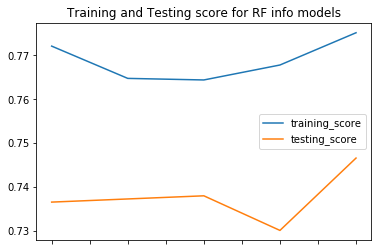

In [116]:
results.loc[['training_score','testing_score'],['RandomForestClassifier_info_1','RandomForestClassifier_info_2','RandomForestClassifier_info_3','RandomForestClassifier_info_4','RandomForestClassifier_info_5']].transpose().plot.line()
plt.title('Training and Testing score for RF info models')
plt.show()

we can above actually see the model is performing better in the training accuracy as we add more variables for each model via polynomial features and removing the amount_invalid feature. It is just that the testing accuracy was reducing, and we can see this is due to overfitting.

#### Discussion on best models and feature importances:

In [117]:
#get best model overall for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()


For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_2,RandomForestClassifier_info_5
pred_time,0.046194,0.046585,0.023288
testing_score,0.818552,0.861297,0.746600
train_time,0.226533,0.223958,0.202344
training_score,0.843931,0.871107,0.775112


Overall, we can see that the top performing models are the 3rd model (with GridSearch to find optimal model parameters and removing amount_invalid column) for predicting effectiveness of BOGO and discount offers, whereas the best performing model for informational offers was just after performing GridSearch to find the optimal parameters.

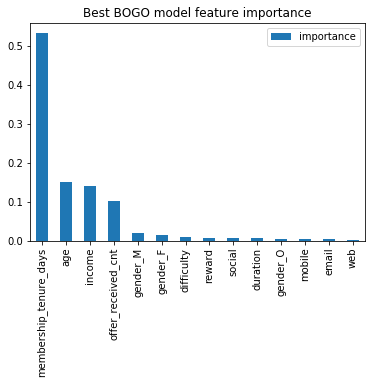

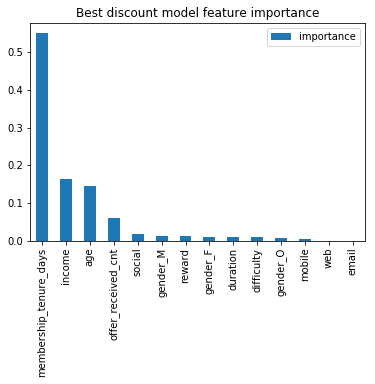

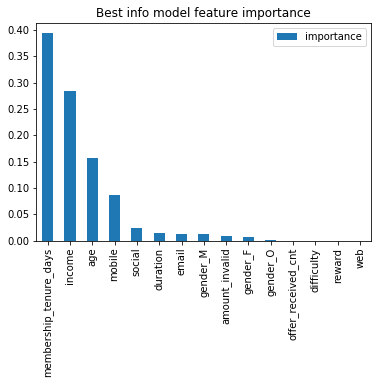

In [118]:
#show feature importance
#BOGO 3 model
#prepare data same as BOGO 3 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']
features,target=data_prep(offers_bogo,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount 3 model
feature_importances = pd.DataFrame(discount_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#info_2 model
#prepare data similar to info_2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

### c. Exploration on users in Groups 3 and 4 - People who purchase regardless of viewing any offer

#### Data Preparation:

In [119]:
#grp 3+4
grp3_4=grp3_bogo.append(grp3_discount,sort=False)
grp3_4=grp3_4.append(grp3_info,sort=False)
grp3_4=grp3_4.append(grp4_bogo,sort=False)
grp3_4=grp3_4.append(grp4_discount,sort=False)
grp3_4=grp3_4.append(grp4_info,sort=False)

#grp1
grp1_all=grp1_bogo.append(grp1_discount,sort=False)
grp1_all=grp1_all.append(grp1_info,sort=False)

#grp2
grp2_all=grp2_bogo.append(grp2_discount,sort=False)
grp2_all=grp2_all.append(grp2_info,sort=False)

#get unique person-offer_id pairs
grp3_4=grp3_4[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
grp1_all=grp1_all[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
grp2_all=grp2_all[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

#get membership_tenure_days
grp3_4=member(grp3_4)
grp1_all=member(grp1_all)
grp2_all=member(grp2_all)

#merge with transcript to check transaction amount
grp3_4=grp3_4.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')
grp1_all=grp1_all.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')
grp2_all=grp2_all.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')

In [120]:
#check null values
print("For grp 3 and 4:")
print((grp3_4.isnull().sum()/len(grp3_4))*100)

#drop null values
grp3_4=grp3_4.dropna()

#check null values
print("For grp 1:")
print((grp1_all.isnull().sum()/len(grp1_all))*100)

#drop null values
grp1_all=grp1_all.dropna()

#check null values
print("For grp 2:")
print((grp2_all.isnull().sum()/len(grp2_all))*100)

#drop null values
grp2_all=grp2_all.dropna()

For grp 3 and 4:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    9.019155
income                    9.019155
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 1:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    5.896762
income                    5.896762
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 2:
person                     0.000000
offer_id                   0.000000
age                        0.000000
gender                    21.131608
income                    21.131608
membership_tenure_days     0.000000
amount                     0.000000
dtype: float64


In [121]:
#create function for plotting multiple histograms overlaying the 3 groups
def plot_hist(variable,bins=None):
    plt.hist(grp1_all[variable],alpha=0.5, label='group 1',bins=bins)
    plt.hist(grp3_4[variable], alpha=0.5, label='group 3 and 4',bins=bins)
    plt.hist(grp2_all[variable], alpha=0.5, label='group 2',bins=bins)
    plt.legend(loc='upper right')
    plt.title('distribution of '+ variable + ' between group 1, group 2 and groups 3 + 4')
    plt.show()

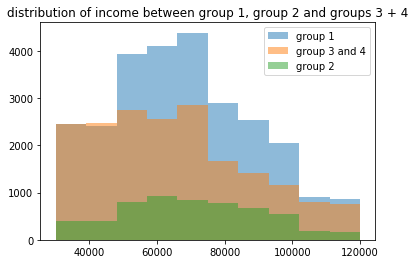

In [122]:
#plot distribution of income
plot_hist('income')

#### all-in-one model

In [123]:
#append datasets together
offers_bogo['offer_type']='bogo'
offers_info['offer_type']='informational'
offers_discount['offer_type']='discount'
offers=offers_discount.append(offers_bogo,sort=False)
offers=offers.append(offers_info,sort=False)

#create dummy variable for offer_type categorical variable
offers=dummy(offers,'offer_type')

In [124]:
#do grid search to find optimal parameters for RF model
drop_cols_prep=['person','offer_id','effective_offer','amount_invalid']
features,target=data_prep(offers,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

rand_forest_param_selection(X_train, y_train)

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'n_estimators': 40}

In [125]:
drop_cols_prep=['person','offer_id','effective_offer','amount_invalid']
features,target=data_prep(offers,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
all_in_one = RandomForestClassifier(random_state=10,criterion='gini',max_depth= 30, max_features= 'auto',min_samples_split= 3,n_estimators=55,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,all_in_one,'all_in_one')],axis=1)


DecisionTreeClassifier trained on 25594 samples.
MSE_train: 0.1792
MSE_test: 0.1786
Training accuracy:0.8208
Test accuracy:0.8214
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000      1143
          1     0.8214    1.0000    0.9019      5256

avg / total     0.6747    0.8214    0.7408      6399



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 25594 samples.
MSE_train: 0.1648
MSE_test: 0.1783
Training accuracy:0.8352
Test accuracy:0.8217
             precision    recall  f1-score   support

          0     0.5056    0.0787    0.1363      1143
          1     0.8307    0.9833    0.9006      5256

avg / total     0.7727    0.8217    0.7641      6399



In [126]:
#comparing best performance of all 3 models with all_in_one model
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_discount_3','RandomForestClassifier_info_2','DecisionTreeClassifier_all_in_one','RandomForestClassifier_all_in_one']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_3,RandomForestClassifier_info_2,DecisionTreeClassifier_all_in_one,RandomForestClassifier_all_in_one
pred_time,0.048769,0.047421,0.018172,0.002797,0.235821
testing_score,0.812856,0.860904,0.737294,0.821378,0.821691
train_time,0.226792,0.229332,0.083682,0.055890,1.259619
training_score,0.847492,0.871598,0.764727,0.820817,0.835235


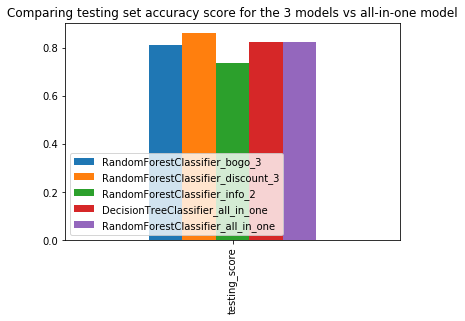

In [127]:
results.loc[['testing_score'],['RandomForestClassifier_bogo_3','RandomForestClassifier_discount_3','RandomForestClassifier_info_2','DecisionTreeClassifier_all_in_one','RandomForestClassifier_all_in_one']].plot.bar()
plt.title('Comparing testing set accuracy score for the 3 models vs all-in-one model')
plt.legend(loc=3)
plt.show()

Comparing the performance of the 3 best models for each offer type with the all_in_one model, we can se that having the all-in-one model is not as good as the RF bogo and discount models, and is about slightly better than the info model. This is probably due to the info model pulling down the performance, resulting in lower accuracy for the all in one model. I suspect that if we were to break down the all-in-one model performance to just looking at its ability to predict the effectiveness of informational offer types, it would also be worse than its performance predicting the other 2 types.

In [128]:
#append all 3 datasets together
grp1=grp1_bogo.append(grp1_discount,sort=False)
grp1=grp1.append(grp1_info,sort=False)

#drop unnecessary columns
drop_cols('effective_offer',grp1,inplace=True)

#get offer details
grp1=grp1.merge(portfolio,how='left',on='offer_id')

In [129]:
#get sum of valid transactions per person based on unique person and offer_id pair
grp1=grp1.merge(transcript[['person','offer_id','amount']][transcript['valid_completed']==1].groupby(['person','offer_id']).sum(),on=['person','offer_id'])

In [130]:
#get demographic data and membership_tenure details
grp1=member(grp1)

#reset index for offers_info
grp1=drop_cols('index',grp1.reset_index())

#reuse offers_info channel_col function to expand channel column into categorical variables
channel_col('web',grp1)
channel_col('email',grp1)
channel_col('mobile',grp1)
channel_col('social',grp1);

drop_cols('channels',grp1,inplace=True);

#reuse offers_info function to prep dataset
grp1=prep_offers_df(grp1)

#encode offer type as dummy variables
grp1=dummy(grp1,'offer_type')

In [131]:
#add one level of dummy variable to drop
drop_cols_prep=['person', 'offer_id','amount','social','gender_O','offer_type_informational']
target=grp1['amount']
features=drop_cols(drop_cols_prep,grp1)

In [132]:
def train_predict_reg(learner, X_train, y_train, X_test, y_test): 
    '''
    input:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    return results

In [133]:
def run_model_reg(clf1,clf2,name):
    '''
    input:
    - clf1: baseline regression model
    - clf2: 2nd regression model to compare
    - name: name to keep track of comparison
    output:
    - dataframe containing results of training and prediction of model
    
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict_reg(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

In [134]:
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

#Initialize the model
clf1 = Ridge(alpha=2,random_state=2)
clf2 = DecisionTreeRegressor(random_state=2)

results_reg=run_model_reg(clf1,clf2,'reg')

Ridge trained on 21011 samples.
MSE_train: 5149.4918
MSE_test: 5264.4857
Training accuracy:0.0901
Test accuracy:0.0863
DecisionTreeRegressor trained on 21011 samples.
MSE_train: 0.0410
MSE_test: 11106.1821
Training accuracy:1.0000
Test accuracy:-0.9277


In [135]:
results_reg

,Ridge_reg,DecisionTreeRegressor_reg
pred_time,0.005491,0.016167
testing_score,0.086260,-0.927664
train_time,0.077697,1.500944
training_score,0.090122,0.999993


### Conclusion

### Question1 conclusion:
If we discuss about Question 1,then the feature importance given by all the three different models that we are using were from where we found that the tenure of a member is the biggest predictor of the effectiveness of an offer. On performing further operations we would be able to calculate the number of average tenure days as a result of an effective BOGO offer.

For all three models given above , the top 3 variables were the same - membership tenure, income and age. However, income and age switched orders depending on offer type.

If we analyze  BOGO and discount offers,we will find that the distribution of feature importances were relatively equal. However, for informational offers, the distribution is slightly more balanced as we can see.

### Question 2 conclusion:

If we discuss aboutr Question 2,I have uesd 3 different models to predict the effectiveness of each offer type and i got a good accuracy value for 2 of the models (87.35% for discount and 82.83% for BOGO), while in other model there is a slightly accurate performance that is in informational offers (75.3%). However, I think 75% as acceptable in a business setting, as for informational offers. 

Meanwhile, an 80% and above accuracy in a business setting is better to show offers to people, as in a business setting that would be acceptable to show offers to people, even if the model misclassifies a few, the overall revenue increase might justify the few mistakes.